In [64]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import streamlit as st
import seaborn as sns
import pandas as pd


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam


plt.style.use('ggplot')





import kaggle

ImportError: cannot import name 'model' from 'tensorflow.keras.models' (C:\Users\opiks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\_tf_keras\keras\models\__init__.py)

In [22]:
kaggle.api.authenticate()
dataset_url = 'taufiqurahman07/castingdataset'
kaggle.api.dataset_download_files(dataset_url, unzip=True)


Dataset URL: https://www.kaggle.com/datasets/taufiqurahman07/castingdataset


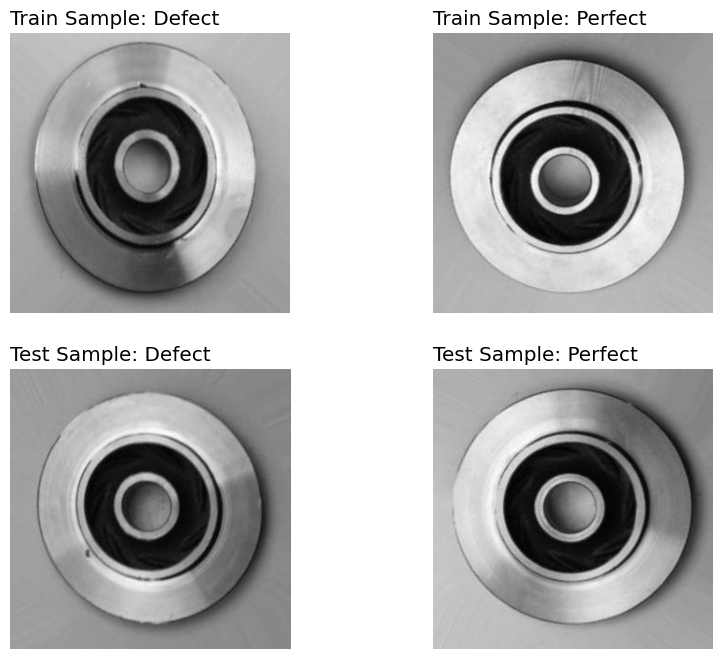

In [44]:
# Specify directory of train data
dir_train = 'castingdataset/train/'
dir_train_def = os.path.join(dir_train, 'def_front/')  # Class label: Defect
dir_train_ok = os.path.join(dir_train, 'ok_front/')    # Class label: Perfect

# Specify directory for test data
dir_test = 'castingdataset/test/'
dir_test_def = os.path.join(dir_test, 'def_front/')
dir_test_ok = os.path.join(dir_test, 'ok_front/')

# Function to create directories
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Create directories for test dataset
create_dir(dir_test_def)
create_dir(dir_test_ok)

# Function to split and move images
def split_and_move_images(src_dir, dest_test_dir, test_size=0.2):
    files = os.listdir(src_dir)
    _, test_files = train_test_split(files, test_size=test_size, random_state=42)
    
    for file_name in test_files:
        src = os.path.join(src_dir, file_name)
        dst = os.path.join(dest_test_dir, file_name)
        shutil.move(src, dst)

# Split and move images for defect and perfect categories
split_and_move_images(dir_train_def, dir_test_def)
split_and_move_images(dir_train_ok, dir_test_ok)

# Function to load the first image from a directory
def load_sample_image(directory):
    files = os.listdir(directory)
    if files:
        return plt.imread(os.path.join(directory, files[0]))
    else:
        raise FileNotFoundError(f"No images found in directory: {directory}")

# Plot samples of defect and perfect casting from train and test datasets
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Load and display images
try:
    sample_def_train = load_sample_image(dir_train_def)
    sample_ok_train = load_sample_image(dir_train_ok)
    sample_def_test = load_sample_image(dir_test_def)
    sample_ok_test = load_sample_image(dir_test_ok)
    
    axes[0, 0].imshow(sample_def_train)
    axes[0, 1].imshow(sample_ok_train)
    axes[1, 0].imshow(sample_def_test)
    axes[1, 1].imshow(sample_ok_test)
    
    axes[0, 0].set_title('Train Sample: Defect', loc='left')
    axes[0, 1].set_title('Train Sample: Perfect', loc='left')  # Updated title
    axes[1, 0].set_title('Test Sample: Defect', loc='left')
    axes[1, 1].set_title('Test Sample: Perfect', loc='left')  # Updated title

    for ax in axes.flatten():
        ax.grid(False)
        ax.axis('off')
    
    plt.show()

except FileNotFoundError as e:
    print(e)

# Create labels.txt file
class_labels = ["Defect", "Perfect"]  # Updated labels
labels_file_path = "labels.txt"

with open(labels_file_path, 'w') as file:
    for label in class_labels:
        file.write(f"{label}\n")

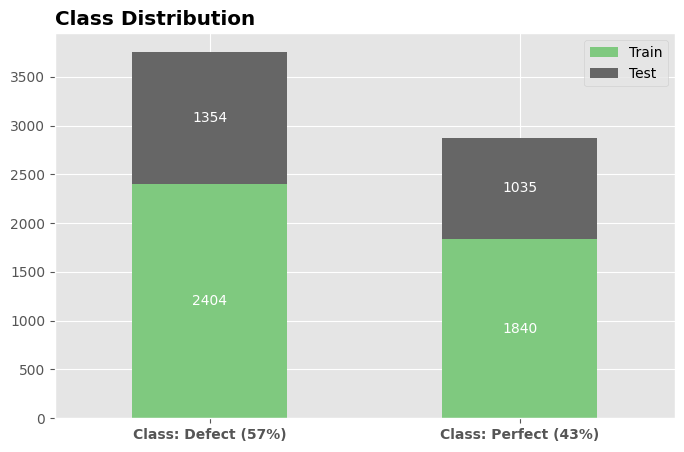

In [45]:
# Create dataframe of class distribution
n_train = [len(os.listdir(dir_train_def)), len(os.listdir(dir_train_ok))]
n_test = [len(os.listdir(dir_test_def)), len(os.listdir(dir_test_ok))]
dist_df = pd.DataFrame(
    data=[n_train, n_test],
    columns=['Defect', 'Perfect'],
    index=['Train', 'Test'])

# Visualize class distribution
ax = dist_df.T.plot(kind='bar', stacked=True, rot=0, figsize=(8,5), colormap='Accent')
ax.set_title('Class Distribution', loc='left', weight='bold')
for bar in ax.patches:
    ax.text(bar.get_x()+bar.get_width()-0.25, 
            bar.get_y()+bar.get_height()/2,
            int(bar.get_height()),
            ha='center', va='center', color='white')
pct_def = 100*dist_df['Defect'].values.sum()/dist_df.values.sum()
pct_ok = 100-pct_def
ax.set_xticklabels([f'Class: Defect ({pct_def:.0f}%)',
                    f'Class: Perfect ({pct_ok:.0f}%)'], weight='bold')
plt.show()

In [47]:
# Define instances of ImageDataGenerator
train_gen = ImageDataGenerator(rotation_range = 360,
                                     width_shift_range = 0.05,
                                     height_shift_range = 0.05,
                                     shear_range = 0.05,
                                     zoom_range = 0.05,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     brightness_range = [0.75, 1.25],
                                     rescale = 1./255,
                                     validation_split = 0.2)
test_gen = ImageDataGenerator(rescale=1./255)

# Specify parameters/arguments for data generation
img_size, batch_size, rand_seed = (300, 300), 64, 0
arg_train = {'target_size': img_size,
             'color_mode': 'grayscale',
             'classes': {'def_front': 0,
                         'ok_front': 1},
             'class_mode': 'binary',
             'batch_size': batch_size,
             'seed': rand_seed}
arg_test = {'target_size': img_size,
            'color_mode': 'grayscale',
            'classes': {'def_front': 0,
                        'ok_front': 1},
            'class_mode': 'binary',
            'batch_size': batch_size,
            'seed': rand_seed,
            'shuffle': False}

# Generate data by iterating through directories
train_set = train_gen.flow_from_directory(
    directory=dir_train, subset='training', **arg_train)
valid_set = train_gen.flow_from_directory(
    directory=dir_train, subset='validation', **arg_train)
test_set = test_gen.flow_from_directory(
    directory=dir_test, **arg_test)

Found 3396 images belonging to 2 classes.
Found 848 images belonging to 2 classes.
Found 2389 images belonging to 2 classes.


In [48]:
# Define CNN model architecture
cnn_model = Sequential([ 
    # First block
    Conv2D(32, 3, activation='relu', padding='same', strides=2,
           input_shape=img_size+(1,)),
    MaxPooling2D(pool_size=2, strides=2),
    # Second block
    Conv2D(64, 3, activation='relu', padding='same', strides=2),
    MaxPooling2D(pool_size=2, strides=2),
    # Flatenning
    Flatten(),
    # Fully connected layers
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')        # Only 1 output
])

# Compile model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Default lr
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Display summary of model architecture
cnn_model.summary()

C:\Users\opiks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 38, 38, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 23104)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,957,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,976,385 (11.35 MB)

 Trainable params: 2,976,385 (11.35 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
import time

In [50]:
# Measure training time
start_time = time.time()

# Fit model using train set and validation set
n_epochs = 20
history = cnn_model.fit(
    train_set,
    validation_data=valid_set,
    epochs=n_epochs,
    callbacks=ModelCheckpoint(
        'Casting_Inspection.keras',
        save_best_only=True,
        monitor='val_loss'),
    verbose=1)

# Calculate training time
training_time = time.time() - start_time
print("Training time: {:.2f} seconds".format(training_time))

Epoch 1/20


C:\Users\opiks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5312 - loss: 0.7928 - val_accuracy: 0.5660 - val_loss: 0.6784
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6038 - loss: 0.6676 - val_accuracy: 0.6993 - val_loss: 0.5839
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 58s 995ms/step - accuracy: 0.6771 - loss: 0.5816 - val_accuracy: 0.7193 - val_loss: 0.5528
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7178 - loss: 0.5454 - val_accuracy: 0.7406 - val_loss: 0.5299
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 981ms/step - accuracy: 0.7439 - loss: 0.5102 - val_accuracy: 0.7877 - val_loss: 0.4698
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7530 - loss: 0.4988 - val_accuracy: 0.8219 - val_loss: 0.4102
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 982ms/step - accuracy: 0.8088 - loss: 0.4148 - val_accuracy: 0.7642 - val_loss: 0.4179
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8172 - loss: 0.3858 - val_accuracy: 0.8491 - val_loss: 0

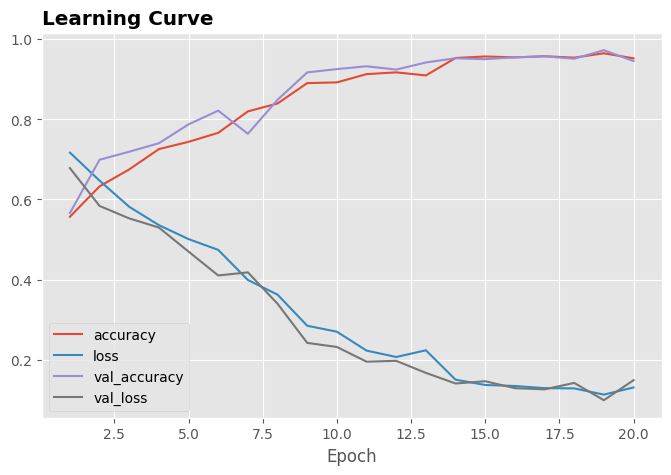

In [56]:
# Plot learning curve from model history
histo_dict = cnn_model.history.history
histo_df = pd.DataFrame(histo_dict, index=range(1,n_epochs+1))
fig, ax = plt.subplots(figsize=(8,5))
for m in histo_df.columns:
    ax.plot(histo_df.index, m, data=histo_df)
ax.set_xlabel('Epoch')
ax.set_title('Learning Curve', loc='left', weight='bold')
ax.legend()
plt.show()

In [57]:
# Load saved model
best_model = load_model('./Casting_Inspection.keras')

# Make predictions on images in the test set
y_pred_prob = best_model.predict(test_set, verbose=1)
y_pred = (y_pred_prob >= 0.5).reshape(-1,)
y_true = test_set.classes[test_set.index_array]

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step


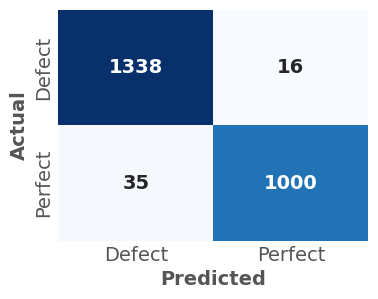

In [58]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Blues')
ax.set_xticklabels(['Defect', 'Perfect'])
ax.set_yticklabels(['Defect', 'Perfect'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

In [34]:
print(classification_report(y_true, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9987    0.9867    0.9926       752
           1     0.9829    0.9983    0.9905       575

    accuracy                         0.9917      1327
   macro avg     0.9908    0.9925    0.9916      1327
weighted avg     0.9918    0.9917    0.9917      1327



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


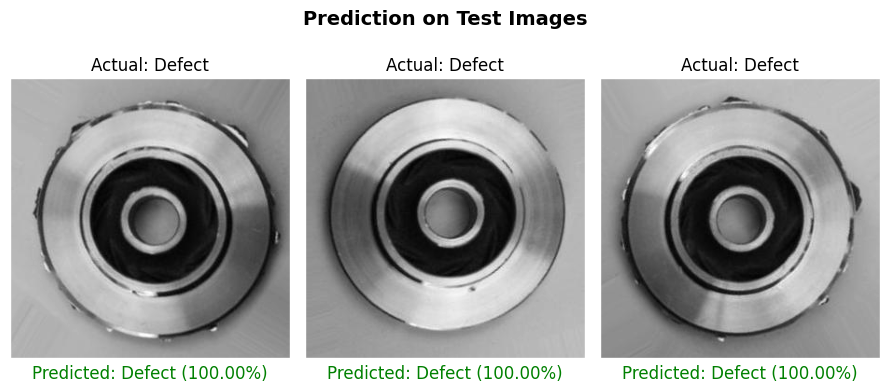

In [61]:
class_map = {0: 'Defect', 1: 'Perfect'}
images, labels = next(iter(test_set))
images = images.reshape(batch_size,*img_size)

fig, axes = plt.subplots(1, 3, figsize=(9, 4))
fig.suptitle('Prediction on Test Images', y=0.98, weight='bold', size=14)
for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img, cmap='gray')
    [[pred_prob]] = best_model.predict(img.reshape(1, *img_size, -1))
    pred_label = class_map[int(pred_prob>=0.5)]
    true_label = class_map[label]
    prob_class = 100*pred_prob if pred_label=='Perfect' else 100*(1-pred_prob)
    ax.set_title(f'Actual: {true_label}', size=12)
    ax.set_xlabel(f'Predicted: {pred_label} ({prob_class:.2f}%)',
                  color='g' if pred_label==true_label else 'r')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


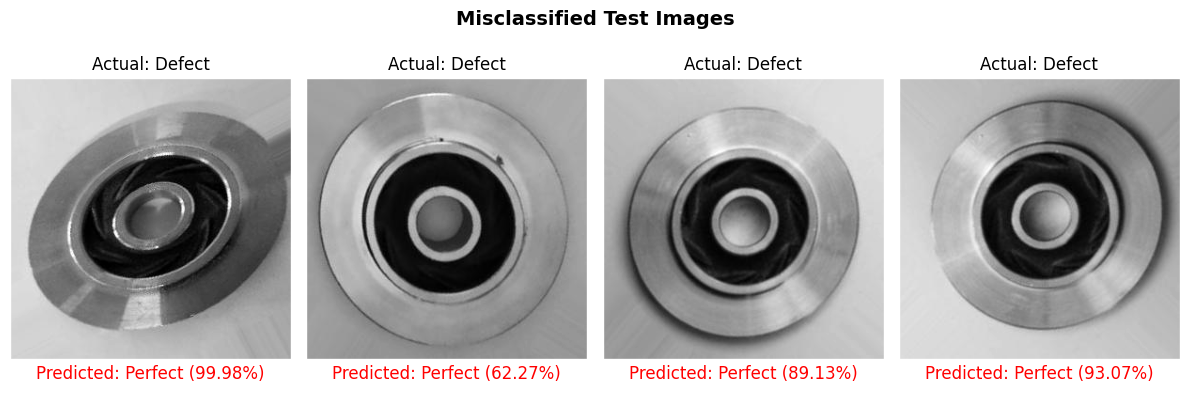

In [62]:
misclassified = np.nonzero(y_pred != y_true)[0]
batch_num = misclassified//batch_size
image_num = misclassified%batch_size

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
fig.suptitle('Misclassified Test Images', y=0.98, weight='bold', size=14)
for ax, bnum, inum in zip(axes.flat, batch_num, image_num):
    images, labels = test_set[bnum]
    img = images[inum]
    ax.imshow(img.reshape(*img_size), cmap='gray')
    [[pred_prob]] = best_model.predict(img.reshape(1, *img_size, -1))
    pred_label = class_map[int(pred_prob>=0.5)]
    true_label = class_map[labels[inum]]
    prob_class = 100*pred_prob if pred_label=='Perfect' else 100*(1-pred_prob)
    ax.set_title(f'Actual: {true_label}', size=12)
    ax.set_xlabel(f'Predicted: {pred_label} ({prob_class:.2f}%)',
                  color='g' if pred_label==true_label else 'r')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [66]:
cnn_model.save("modelcast.h5")